#Import libraries

In [1]:
!python -m nltk.downloader stopwords

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import string
import pandas as pd
import re
import joblib
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df=pd.read_csv("News Detections_Training Part.csv")
df

news_url  \
0      http://toofab.com/2017/05/08/real-housewives-a...   
1      https://www.today.com/style/see-people-s-choic...   
2      https://www.etonline.com/news/220806_sophia_bu...   
3      https://www.dailymail.co.uk/news/article-33655...   
4      https://www.zerchoo.com/entertainment/gossip-g...   
...                                                  ...   
16994  https://www.kqed.org/pop/28206/how-amber-rose-...   
16995  www.usmagazine.com/celebrity-moms/news/rihanna...   
16996  https://www.longroom.com/discussion/710361/kou...   
16997  https://www.mid-day.com/articles/emmy-awards-2...   
16998  gunrights.trendolizer.com/2017/10/jason-aldean...   

                   source_domain  real  \
0                     toofab.com     1   
1                  www.today.com     1   
2               www.etonline.com     1   
3            www.dailymail.co.uk     1   
4                www.zerchoo.com     1   
...                          ...   ...   
16994               www.kqed.org     1   
16995         www.usmagazine.com     0   
16996           www.longroom.com     1   
16997            www.mid-day.com     1   
16998  gunrights.trendolizer.com     0   

                                                    news  news_reply  
0      Kandi Burruss Explodes Over Rape Accusation on...          42  
1      People's Choice Awards 2018: The best red carp...           0  
2      Sophia Bush Sends Sweet Birthday Message to 'O...          63  
3      Colombian singer Maluma sparks rumours of inap...          20  
4      Gossip Girl 10 Years Later: How Upper East Sid...          38  
...                                                  ...         ...  
16994    How Amber Rose Became an Unlikely Feminist Icon          67  
16995  Rihanna Cradles Newborn Baby in Loving Twitter...          81  
16996  Kourtney Kardashian and Younes Bendjima Are Ma...          56  
16997  Emmy Awards 2017: Elisabeth Moss found out abo...           8  
16998  Jason Aldean Gig Canceled After He Sells Out T...          22  

[16999 rows x 5 columns]

# Cleaning the Dataset

In [5]:
df.drop(columns=['news_reply','news_url','source_domain'],inplace=True)


In [6]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16999 rows x 2 columns]

# Handling Duplicated Values

In [7]:
df.duplicated().sum()

817

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16182 rows x 2 columns]

In [11]:
df.isnull()

real   news
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
16994  False  False
16995  False  False
16996  False  False
16997  False  False
16998  False  False

[16182 rows x 2 columns]

In [12]:
df.isnull().sum()

real    0
news    0
dtype: int64

In [13]:
df.describe()

real
count  16182.000000
mean       0.758126
std        0.428231
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

## Text Cleaning

In [14]:
STOP_WORDS = set(stopwords.words("english"))

LEMMATIZER = WordNetLemmatizer()


def clean_mentions(text: str):
    return re.sub(r"@[a-zA-Z0-9_]+", "", text)


def clean_URLs(text: str):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)


def clean_HTML5_entities(text: str):
    return re.sub(r"&[a-z]+;", "", text)


def clean_punctuations(text: str):
    return re.sub(r"\W", " ", text)


def clean_numbers(text: str):
    return re.sub(r"[0-9]+", "", text)


def clean_stopwords(text: str):
    return " ".join([token for token in text.split() if token not in STOP_WORDS])


def lemmatize_text(text: str):
    return " ".join([LEMMATIZER.lemmatize(token, pos="v") for token in text.split()])


def normalize(text: str):
    text = text.lower()
    text = clean_mentions(text)
    text = clean_URLs(text)
    text = clean_HTML5_entities(text)
    text = clean_punctuations(text)
    text = clean_numbers(text)
    text = clean_stopwords(text)
    text = lemmatize_text(text)
    return text

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
df["news"] = df["news"].apply(str.lower)
df['news'] = df['news'].apply(clean_URLs)
df['news'] = df['news'].apply(clean_HTML5_entities)
df['news'] = df['news'].apply(clean_numbers)
df['news'] = df['news'].apply(clean_stopwords)
df['news'] = df['news'].apply(clean_punctuations)
df["news"] = df["news"].apply(lemmatize_text)
display(df['news'])

0        kandi burruss explode rape accusation real hou...
1               people s choice award best red carpet look
2        sophia bush send sweet birthday message one tr...
3        colombian singer maluma spark rumour inappropr...
4        gossip girl years later upper east siders shoc...
                               ...                        
16994             amber rise become unlikely feminist icon
16995     rihanna cradle newborn baby love twitter picture
16996    kourtney kardashian younes bendjima make paris...
16997        emmy award elisabeth moss find nomination gif
16998            jason aldean gig cancel sell liberals snl
Name: news, Length: 16182, dtype: object

# Vectorize The Text

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Max words
tfidf_features = tfidf_vectorizer.fit_transform(df['news'])

## Spliting the data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_features, df['real'], test_size=0.2, random_state=42) # x,y

## Model Training

In [19]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

## Model Accuracy

In [20]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.8331788693234476


# Confusion Matrix and Accuracy

In [21]:
# Step 1: Confusion Matrix and Accuracy
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)

Confusion Matrix:
[[ 333  455]
 [  85 2364]]
Accuracy: 0.8331788693234476


Confusion Matrix:
[[ 333  455]
 [  85 2364]]


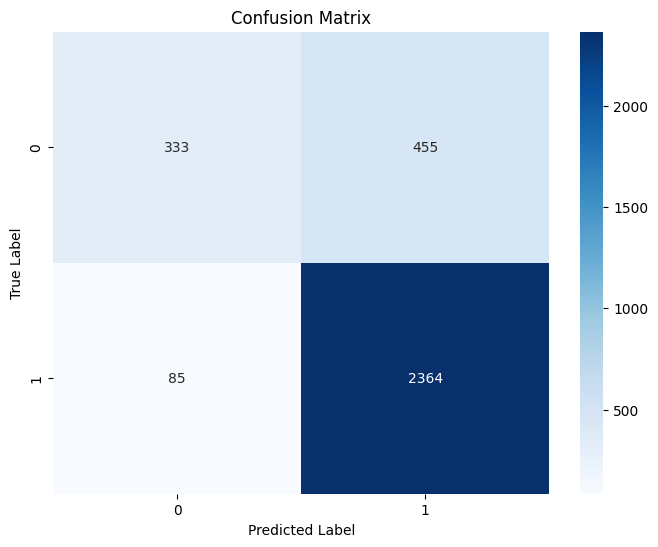

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Step 2: Precision, Recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.42      0.55       788
           1       0.84      0.97      0.90      2449

    accuracy                           0.83      3237
   macro avg       0.82      0.69      0.72      3237
weighted avg       0.83      0.83      0.81      3237



Cross Validation

In [24]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
scores = cross_val_score(model, tfidf_features, df['real'], cv=5)  # cv=5 for 5-fold cross-validation

# Print the average accuracy across all folds
print("Cross-Validation Mean Accuracy:", scores.mean())


Cross-Validation Mean Accuracy: 0.8286368255182944


Rondom search

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameter distributions
param_dist = {
    'C': uniform(loc=0, scale=10),
    'penalty': ['l1', 'l2']
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000), param_distributions=param_dist, n_iter=10, cv=5)

# Perform random search
random_search.fit(tfidf_features, df['real'])

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)


Best Hyperparameters: {'C': 5.036382815778956, 'penalty': 'l2'}


C:\Users\Electronica\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Electronica\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Electronica\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Electronica\AppData\Roaming

Grid search

In [26]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their values to search through
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2']
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=param_grid, cv=5)

# Perform grid search
grid_search.fit(tfidf_features, df['real'])

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'C': 1.0, 'penalty': 'l2'}


C:\Users\Electronica\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Electronica\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Electronica\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Electronica\AppData\Roaming

# AUC-ROC Curve

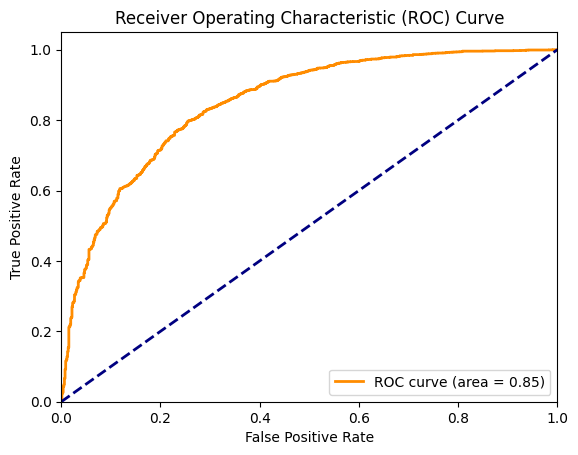

In [27]:
# Step 3: AUC-ROC Curve
y_probs = model.predict_proba(x_test)[:,1]
auc_roc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Process User Input and Predict

In [28]:
def preprocess_input(text):
    cleaned_text = normalize(text)
    transformed_text = tfidf_vectorizer.transform([cleaned_text]).toarray()
    return transformed_text

def predict_real_or_fake(text):
    transformed_text = preprocess_input(text)
    prediction = model.predict(transformed_text)
    real_or_fake_mapping = {0: 'fack',1:'real'}
    real_or_fake = real_or_fake_mapping[prediction[0]]
    return real_or_fake

## Test with User Input

In [29]:
text="Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)"
real_or_fake = predict_real_or_fake(text)
print(f"Text: '{text}'")
print(f"Predicted Real or Fake: {real_or_fake}\n")

Text: 'Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)'
Predicted Real or Fake: real



In [30]:
df['news'] = df['news'].apply(preprocess_input)

# save the model

In [31]:
joblib.dump(model, "real_or_fake_model.logisticRegression")

['real_or_fake_model.logisticRegression']